In [4]:
import os
import uproot
import pandas as pd
import awkward as ak
import math
import os
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import nbformat
import sklearn.metrics as metrics
from itertools import combinations
print(nbformat.__version__)

5.10.4


In [22]:
WEBSITE = '/web/gbrodbek/public_html'

In [23]:
df = pd.read_pickle("run3_newdatalabels/testruns/modelsaves/model_output_eval_logits.pt")
df.keys()

Index(['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0', 'background',
       'labels_true', 'energy'],
      dtype='object')

## One-vs-rest ROC curves

AUC for e: 0.9975420349787422
AUC for mu: 0.9991236902868528
AUC for pi_pi0: 0.967482071970646
AUC for pi: 0.985334168033614
AUC for pi_2pi0: 0.9472624478134197
AUC for 3pi: 0.9859383639300798
AUC for 3pi_pi0: 0.9639190288052006


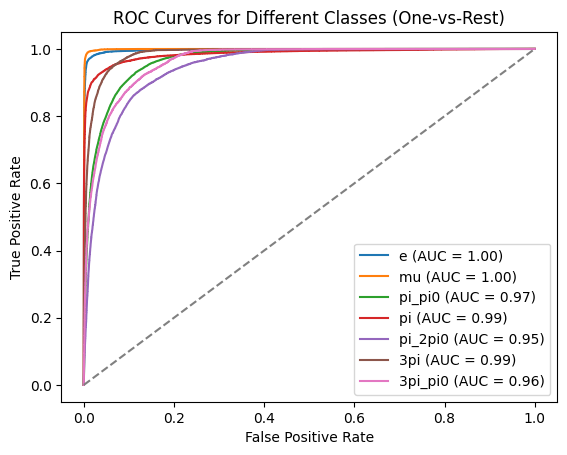

In [24]:
probs_columns = ['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0']
labels = df['labels_true']
fpr_list, tpr_list, auc_list = [], [], []

# Iterate over each probability column and treat it as a binary classification (one-vs-rest)
for i, prob_col in enumerate(probs_columns):
    probs = df[prob_col]  # Probabilities for the current class
    fpr, tpr, thresholds = metrics.roc_curve(labels, probs, pos_label=i)  # pos_label=i for binary ROC curve
    auc = metrics.auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    
    print(f"AUC for {prob_col}: {auc}")

# Plot ROC curves for each class
# plt.figure(figsize=(10, 6))
for fpr, tpr, auc, prob_col in zip(fpr_list, tpr_list, auc_list, probs_columns):
    plt.plot(fpr, tpr, label=f"{prob_col} (AUC = {auc:.2f})")
    
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Classes (One-vs-Rest)")
plt.legend(loc="lower right")
# plt.savefig(os.path.join(WEBSITE, 'ROC_curves' ,'ROC_all_vs_rest.png'))
plt.show()

## One-vs-one ROC curves:

AUC for 3pi_pi0: 0.843578312874563


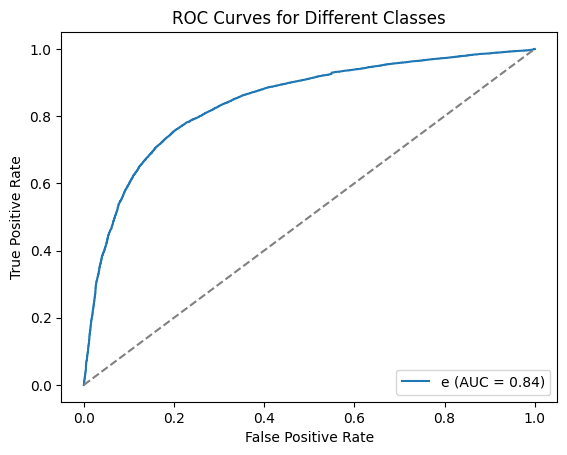

In [25]:
# filter only events from e and mu classes
filter = (df.labels_true == 2) | (df.labels_true == 4)
df_filtered = df[filter]
labels_filtered = df_filtered['labels_true']


probs = df_filtered['pi_pi0']  # Probabilities for the current class
fpr, tpr, thresholds = metrics.roc_curve(labels_filtered, probs, pos_label=2)  # pos_label=i for binary ROC curve
auc = metrics.auc(fpr, tpr)
print(f"AUC for {prob_col}: {auc}")

plt.plot(fpr, tpr, label=f"e (AUC = {auc:.2f})")
    
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Classes")
plt.legend(loc="lower right")
plt.show()

In [26]:
def plot_ROC(df, decayclass, save_path=None, figshow=True):
    decays = ['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0']   # check if valid decay mode is given
    if decayclass not in decays:
        print("Invalid decay mode, please choose from: ", decays)
        return
    index_decay = decays.index(decayclass)          # find index of decay mode

    # plot the ROC curve against all other classes
    fpr, tpr, thresholds = metrics.roc_curve(df['labels_true'], df[decayclass], pos_label=index_decay)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"all (AUC = {auc:.2f})")
    
    # iterate over all other classes and plot the ROC curve against them
    for i, decay in enumerate(decays):
        if decay == decayclass:    # skip the decay mode itself
            continue
        filter = (df.labels_true == index_decay) | (df.labels_true == i)        # filter only events from the two classes
        labels_filtered = df[filter]['labels_true']
        scores = df[filter][decayclass]
        fpr, tpr, thresholds = metrics.roc_curve(labels_filtered, scores, pos_label=index_decay)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{decay} (AUC = {auc:.2f})")

    plt.title(f"ROC Curves for {decayclass} against the other Classes")    
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    
    if save_path: plt.savefig(save_path)
    plt.show() if figshow else plt.close()
    

In [27]:
# # save them all to the webpage
# decays = ['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0']
# for decay in decays:
#     save_path = os.path.join(WEBSITE, 'ROC_curves', f"ROC_{decay}.png")
#     plot_ROC(df, decay, save_path=save_path, figshow=False)

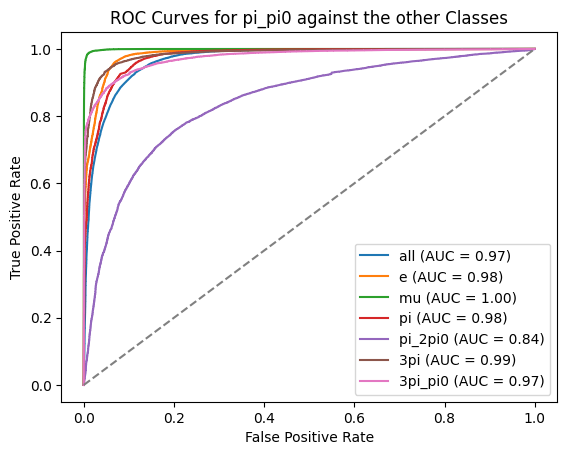

In [28]:
plot_ROC(df, 'pi_pi0')

In [5]:
[actual, predicted, counts] = np.genfromtxt('modelDataForMaria.csv', delimiter=',', skip_header=1, dtype=None).T
counts = np.array([float(x.strip('"')) for x in counts])
actual = np.array([(x.strip('"')) for x in actual])
predicted = np.array([(x.strip('"')) for x in predicted])

In [6]:


# Einzigartige Werte für Zeilen und Spalten
unique_actual = sorted(set(actual))
unique_predicted = sorted(set(predicted))

# Initialisiere DataFrame mit Nullen
df = pd.DataFrame(0, index=sorted(set(actual)), columns=sorted(set(predicted)))

# Füllen des DataFrame mit `.loc`
for idx, count in enumerate(counts):
    df.loc[actual[idx], predicted[idx]] = count

df


,0: e,1: mu,2: pi pi0,3: pi,4: pi 2pi0,5: 3pi,6: 3pi pi0,7: background
0: e,14743,158,508,153,2,0,0,0
1: mu,51,18606,24,195,0,0,0,0
2: pi pi0,145,35,21753,336,1189,594,595,0
3: pi,224,296,825,10378,4,269,42,0
4: pi 2pi0,22,8,4077,11,4312,146,723,0
5: 3pi,0,1,314,4,4,7401,1076,0
6: 3pi pi0,2,1,525,2,406,1170,3892,0
7: background,0,0,0,0,0,0,0,0


In [7]:
df = pd.DataFrame(0, index=sorted(set(actual)), columns=sorted(set(predicted)))  # initialise DataFrame with zeros

for idx, count in enumerate(counts):                    # fill Dataframe
    df.loc[actual[idx], predicted[idx]] = count

df

,0: e,1: mu,2: pi pi0,3: pi,4: pi 2pi0,5: 3pi,6: 3pi pi0,7: background
0: e,14743,158,508,153,2,0,0,0
1: mu,51,18606,24,195,0,0,0,0
2: pi pi0,145,35,21753,336,1189,594,595,0
3: pi,224,296,825,10378,4,269,42,0
4: pi 2pi0,22,8,4077,11,4312,146,723,0
5: 3pi,0,1,314,4,4,7401,1076,0
6: 3pi pi0,2,1,525,2,406,1170,3892,0
7: background,0,0,0,0,0,0,0,0


In [8]:
df2 = pd.DataFrame(0, index=sorted(set(actual)), columns=sorted(set(predicted)))  # initialise DataFrame with zeros


for i in sorted(set(actual)):                    # fill Dataframe
    for j in sorted(set(predicted)):
        df2.loc[i, j] = round(df.loc[i, j] / df.loc[i].sum(), 4)

df2 = df2.drop(columns=["7: background"], index=["7: background"])  # drop background class
df2

/tmp/ipykernel_2949729/3181070911.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2.loc[i, j] = round(df.loc[i, j] / df.loc[i].sum(), 4)
/tmp/ipykernel_2949729/3181070911.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0102' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2.loc[i, j] = round(df.loc[i, j] / df.loc[i].sum(), 4)
/tmp/ipykernel_2949729/3181070911.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0326' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2.loc[i, j] = round(df.loc[i, j] / df.loc[i].sum(), 4)
/tmp/ipykernel_2949729/31810709

,0: e,1: mu,2: pi pi0,3: pi,4: pi 2pi0,5: 3pi,6: 3pi pi0
0: e,0.9473,0.0102,0.0326,0.0098,0.0001,0.0000,0.0000
1: mu,0.0027,0.9857,0.0013,0.0103,0.0000,0.0000,0.0000
2: pi pi0,0.0059,0.0014,0.8826,0.0136,0.0482,0.0241,0.0241
3: pi,0.0186,0.0246,0.0685,0.8621,0.0003,0.0223,0.0035
4: pi 2pi0,0.0024,0.0009,0.4384,0.0012,0.4637,0.0157,0.0778
5: 3pi,0.0000,0.0001,0.0357,0.0005,0.0005,0.8410,0.1223
6: 3pi pi0,0.0003,0.0002,0.0875,0.0003,0.0677,0.1951,0.6489


In [47]:
df2.to_csv('confusion_matrix_normalized.csv')

# THESIS PLOT FROM HERE